In [18]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions

import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.layers import Input, Dropout, Flatten, Dense, TimeDistributed, Concatenate

In [19]:
vgg16 = VGG16(weights='imagenet', include_top=True)
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

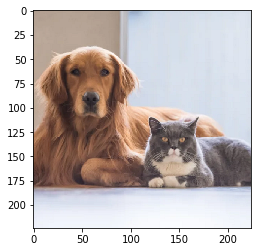

[INFO] classifying image with VGG16...
<class 'list'>
1. golden_retriever: 81.34%
2. Irish_setter: 2.61%
3. tennis_ball: 2.27%
4. Tibetan_mastiff: 1.75%
5. flat-coated_retriever: 1.72%


In [29]:
#img_path = 'C:/Users/ustundag/Desktop/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_25_domain_rgb.png'
img_path = 'cat-dog.png'
img = load_img(img_path, target_size=(224, 224))
data = img_to_array(img)
data = np.expand_dims(data, axis=0)
data = preprocess_input(data)
plt.imshow(img)
plt.show()

print("[INFO] classifying image with VGG16...")
preds = vgg16.predict(data)
P = decode_predictions(preds)
print(type(P))

# loop over the predictions and display the rank-5 predictions
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

In [22]:
from keras.layers import Layer
from keras import backend as K
import tensorflow as tf

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        4D tensor with shape:
        `(1, rows, cols, channels)`.
        X_roi:
        `(1, num_rois, 4)` list of rois, with ordering (x, y, w, h)
    # Output shape
        A tensor with shape:
        `(1, num_rois, pool_size, pool_size, channels)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]
    
    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)
        img  = x[0]
        rois = x[1]
        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], 
                                        (self.pool_size, self.pool_size))
            outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'num_rois': self.num_rois
        }
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [23]:
input_img = Input(shape=(224,224,3))
input_roi = Input(shape=(1,4))

# Block 1
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same',name='block1_conv1')(input_img)
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
# Block 2
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
# Block 3
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
# Block 4
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
# Block 5
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3')(x)
#x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x = RoiPoolingConv(7, 1)([x, input_roi])
# Classification block
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(1000, activation='softmax', name='predictions')(x)

model = Model([input_img, input_roi], x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_18[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [24]:
model.load_weights('C:/Users/ustundag/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

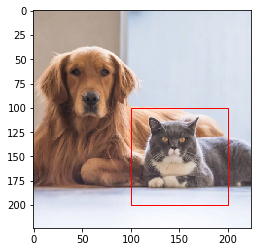

In [53]:
from matplotlib.patches import Rectangle

fig,ax = plt.subplots(1)
ax.imshow(img)
rect = Rectangle((100,100),100,100,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [63]:
num_rois=1
rois = np.zeros((1,num_rois,4))
ratio = 14/224 # input shape is 14x14 feature maps
x_y = np.floor(100*ratio)
w_h = np.floor(100*ratio)
rois[0,0] = [x_y, x_y, w_h, w_h]

preds = model.predict([data, rois])

P = decode_predictions(preds)
# loop over the predictions and display the rank-5 predictions
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

1. lynx: 37.99%
2. Egyptian_cat: 22.35%
3. tiger_cat: 13.46%
4. tabby: 12.88%
5. cougar: 5.93%
